# AML Assignment 1
Lorenzo Dufour, Matthew Hardy\
February 11, 2025


We will focus on the [action](https://www.cftc.gov/PressRoom/PressReleases/8270-20) filled by the CFTC on October 1st, 2020 against BitMEX for violations of the Bank Secrecy Act (BSA) by failing to meet AML and KYC standards, which resulted in a US$100 Million [fine](https://www.justice.gov/usao-sdny/pr/global-cryptocurrency-exchange-bitmex-fined-100-million-violating-bank-secrecy-act) on January 15th, 2025. \
The firm as been recognized guilty to have "Willfully Flouted U.S. Anti-Money Laundering Laws to Boost Revenue" (DOJ)

The following analysis has been performed on a dataset provided by Dott. Francesco Ambrosini.

### Libraries

In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

### Data import

In [14]:
data = pd.read_csv("./crypto_synth.csv")

data['date']=pd.to_datetime(data['date'])

# Filter data for period and columns of interest
data = data[(data['date']>='2020-09-01') & (data['date']<='2020-10-31')]
data = data.drop(['direction', 'volume', 'mean_tx', 'DM_to', 'DM_from'], axis=1).reset_index(drop=True)

## Volume Analysis

### Whole Market

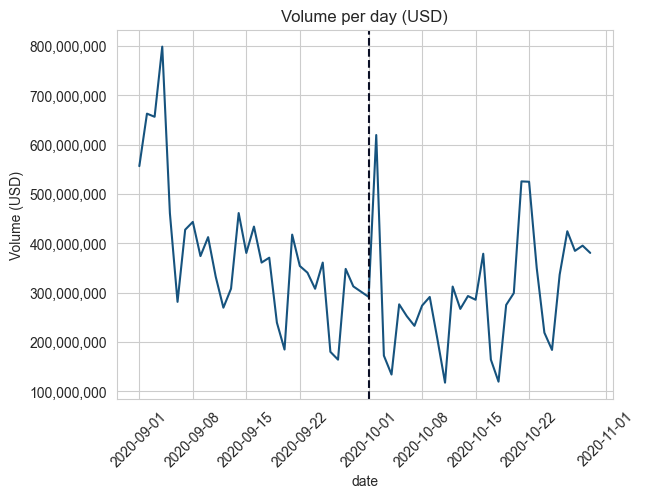

In [15]:
# total volume_USD per day
vol_day = data.groupby('date')['volume_USD'].sum().reset_index()

sns.set_style("whitegrid")
g = sns.lineplot(x='date', y='volume_USD', data=vol_day, color='#16537e', legend=False)
g.set_title('Volume per day (USD)')
g.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='#0b0f25', linestyle='--')
plt.ylabel('Volume (USD)')
plt.show()

A spike of `volume_USD` can be identified on Oct. 2nd, 2020, the day after the CFTC publicly announce its action.

### BitMEX

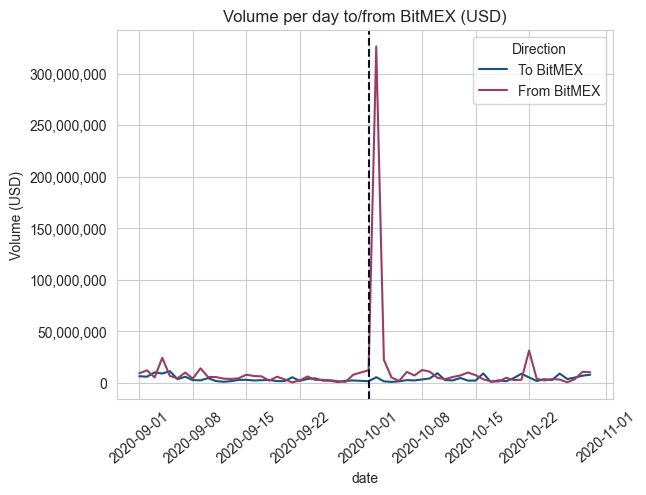

In [16]:
# Subset data for tx from and to BitMEX
vol_day_toBM = data[data['name_to'] == 'BitMEX'].groupby('date')[['n_tx', 'volume_USD']].sum().reset_index()
vol_day_fromBM = data[data['name_from'] == 'BitMEX'].groupby('date')[['n_tx', 'volume_USD']].sum().reset_index()

# Merge data and melt+rename for plotting
vol_day_BM = vol_day_toBM.merge(vol_day_fromBM, on='date', how='outer', suffixes=['_to', '_from'])
vol_day_BM = pd.melt(vol_day_BM, id_vars='date', value_vars=['volume_USD_to', 'volume_USD_from'], var_name='to_from', value_name='volume_USD')
vol_day_BM['to_from'] = vol_day_BM['to_from'].replace({'volume_USD_to': 'To BitMEX', 'volume_USD_from': 'From BitMEX'})

sns.set_style("whitegrid")
g = sns.lineplot(data = vol_day_BM, x = 'date', y='volume_USD', hue='to_from', palette=['#16537e', '#993d66'])
g.set_title('Volume per day to/from BitMEX (USD)')
g.legend(title='Direction')
g.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.xticks(rotation=40)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='#0b0f25', linestyle='--')
plt.ylabel('Volume (USD)')
plt.show()

Focusing on `volume_USD` to or from BitMEX, the spike is even clearer. Considereing the discrimination between from and to transactions, it can be said that this unusual high volume is due to a spike of transactions from BM, i.e. out of BM.

## Coin Analysis

### Coin Comparison

In [17]:
BM_tx = data[data['name_from'] == 'BitMEX']\
    .groupby(['date', 'blockchain'])[['n_tx', 'volume_USD', 'mean_tx_USD']]\
        .agg({'n_tx':'sum', 'volume_USD':'sum', 'mean_tx_USD':'mean'}).reset_index()

BM_tx['blockchain'].unique()

array(['BTC'], dtype=object)

Only Bitcoin transactions were made on that period on BitMEX, no coin comparison analysis to be done.

### Coin Price

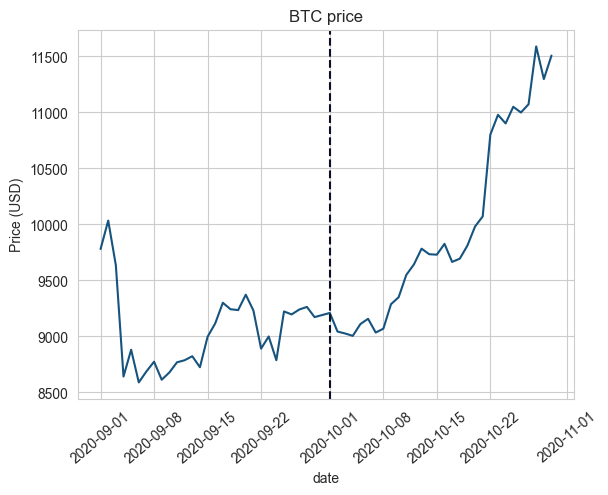

In [18]:
# Import BTC price data downloaded from CoinMarketCap
btc_price = pd.read_csv('BTC_price.csv', sep=';')

btc_price['timeOpen'] = pd.to_datetime(btc_price['timeOpen'])
btc_price = btc_price[['timeOpen', 'open', 'marketCap']]
btc_price.columns = ['date', 'btc_price', 'btc_marketCap']

# Set UTC time for BM_tx to avoid merging issues
BM_tx['date'] = pd.to_datetime(BM_tx['date'], utc=True)
BM_tx = BM_tx.merge(btc_price, on='date', how='left')

sns.lineplot(data=BM_tx, x='date', y='btc_price', color='#16537e')
plt.title('BTC price')
plt.ylabel('Price (USD)')
plt.xticks(rotation=40)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='#0b0f25', linestyle='--')
plt.show()

No clear change in BTC price explaining the spike of transfers to be found.

## Transaction Value Analysis

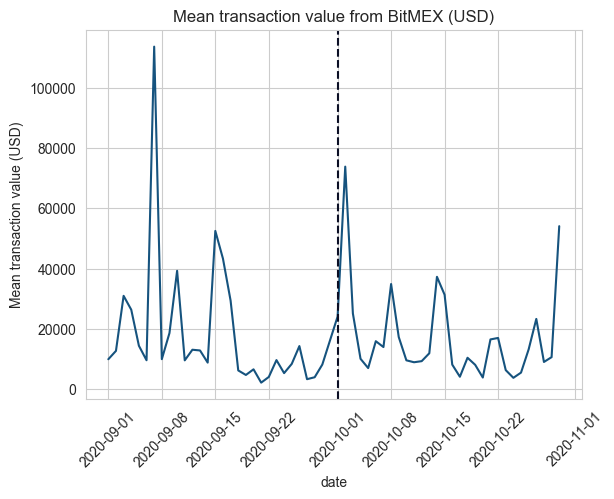

In [19]:

sns.set_style("whitegrid")
sns.lineplot(data = BM_tx, x = 'date', y='mean_tx_USD', hue='blockchain', palette=['#16537e'], legend=False)
plt.title('Mean transaction value from BitMEX (USD)')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-10-01'), color='#0b0f25', linestyle='--')
plt.ylabel('Mean transaction value (USD)')
plt.show()

There is a spike in `mean_tx_USD`, but not outstanding considering the spike of Sep 7, 2020.

## Transaction Destination Type Analysis

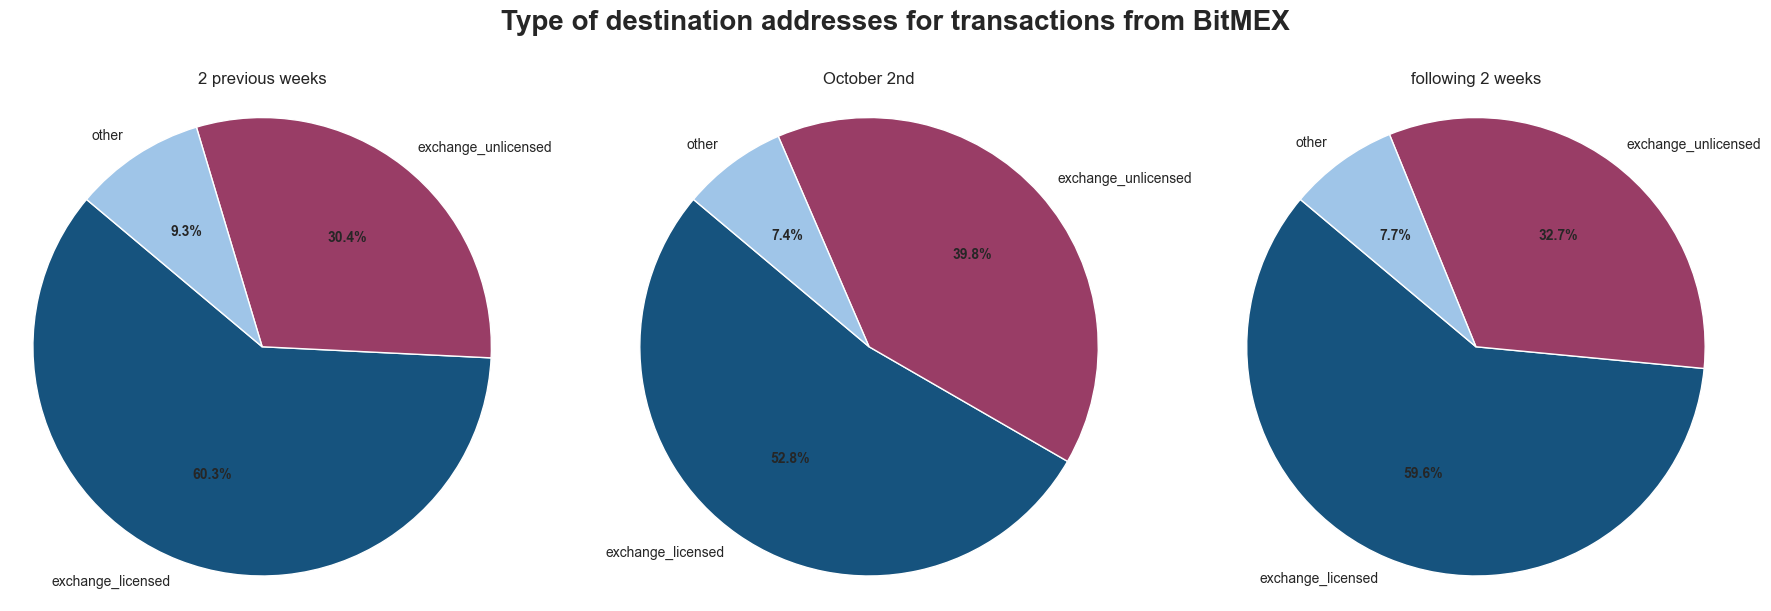

In [20]:
# Subsets for before, on, and after specific dates
from_BM_up_to_oct1 = data[(data['date'] >= '2020-09-18') & (data['date'] <= '2020-10-01') & (data['name_from'] == 'BitMEX')]
from_BM_oct2 = data[(data['date'] == '2020-10-02') & (data['name_from'] == 'BitMEX')]
from_BM_as_of_oct3 = data[(data['date'] >= '2020-10-03') & (data['date'] <= '2020-10-16') & (data['name_from'] == 'BitMEX')]

# Function to group values and plot a pie chart
def plot_pie(ax, data, column, title):
    data.loc[:, column] = data[column].apply(lambda x: x if x in ['exchange_licensed', 'exchange_unlicensed'] else 'other')
    counts = data[column].value_counts()
    wedges, texts, autotexts = ax.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=sns.color_palette(["#16537e", "#993d66", "#9fc5e8"]), startangle=140)
    ax.set_title(title)
    for text in texts + autotexts:
        text.set_fontsize(10)
    plt.setp(autotexts, size=10, weight="bold")
    ax.axis('equal')  # Ensure that the pie chart is drawn as a circle.

# Create a figure with a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the pie charts
plot_pie(axes[0], from_BM_up_to_oct1, 'type_to', '2 previous weeks')
plot_pie(axes[1], from_BM_oct2, 'type_to', 'October 2nd')
plot_pie(axes[2], from_BM_as_of_oct3, 'type_to', 'following 2 weeks')

# Add a suptitle with a larger font size and bold font weight
fig.suptitle('Type of destination addresses for transactions from BitMEX', fontsize=20, fontweight='bold', y=1.01)

plt.tight_layout()
plt.show()

There is a clear change in `type_to` repartition on the vicinity compared to the spike day (Oct 2, 2020).